In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle,os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras import regularizers, optimizers
import sys, os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Using TensorFlow backend.


In [2]:
#plt.rcParams['figure.figsize'] = [6.32, 5.11]
#plt.rcParams['figure.constrained_layout.use'] = True

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelpad'] = 15

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 3

plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.major.width'] = 3

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.markerscale'] = 1

plt.rcParams['lines.markersize'] = 9
plt.rcParams['lines.linewidth'] = 2

In [3]:
path = '../Data/'

In [4]:
L = 40
temp_val = np.arange(0.25, 4.0001, 0.25)
temp_samples = 10000
total_samples = temp_samples * temp_val.shape[0]
test_size = 0.1
val_size = 0.2

In [5]:
split_tc = True

In [6]:
data = pickle.load(open(path + 'Ising2DFM_reSample_L40_T=All.pkl','rb'))
data = np.unpackbits(data).reshape(-1, L * L).astype(float)
data[np.where(data==0)]=-1

labels = pickle.load(open(path + 'Ising2DFM_reSample_L40_T=All_labels.pkl','rb'))

In [7]:
first_tc = np.where(temp_val <= 2.)[0][-1] * temp_samples
last_tc = np.where(temp_val >= 3.)[0][1] * temp_samples

In [8]:
temp_labels = np.hstack([np.repeat(temp, temp_samples) for temp in temp_val])

In [9]:
if split_tc:
    
    X_ordered = data[:first_tc, :]
    Y_ordered = np.column_stack((labels[:first_tc], temp_labels[:first_tc]))

    X_critical = data[first_tc:last_tc, :]
    Y_critical = np.column_stack((labels[first_tc:last_tc], temp_labels[first_tc:last_tc]))

    X_disordered = data[last_tc:, :]
    Y_disordered = np.column_stack((labels[last_tc:], temp_labels[last_tc:]))

    X = np.concatenate((X_ordered, X_disordered))
    Y = np.concatenate((Y_ordered, Y_disordered))
    
    del X_ordered, Y_ordered, X_disordered, Y_disordered, data, labels
    
else:
    
    X = data
    Y = np.column_stack((labels, temp_labels))
    
    del data, labels

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size)

del X, Y

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], L, L, 1))
X_test = np.reshape(X_test, (X_test.shape[0], L, L, 1))
X_val = np.reshape(X_val, (X_val.shape[0], L, L, 1))
X_critical = np.reshape(X_critical, (X_critical.shape[0], L, L, 1))

In [12]:
model = Sequential()

model.add(Conv2D(filters=10, kernel_size=(3, 3), activation='relu', input_shape=(L, L, 1)))

#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(filters=20, kernel_size=(3, 3), activation='relu'))

#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
          
model.add(Dropout(0.5))
          
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 38, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3610)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                231104    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 231,269
Trainable params: 231,269
Non-trainable params: 0
________________________________________________

In [14]:
history = model.fit(X_train, Y_train[:, 0], validation_split=0.1,batch_size=128, epochs=2)


Train on 71280 samples, validate on 7920 samples
Epoch 1/3
71280/71280 [==============================] - 4s 59us/step - loss: 0.0052 - accuracy: 0.9979 - val_loss: 4.1348e-07 - val_accuracy: 1.0000
Epoch 2/3
71280/71280 [==============================] - 3s 49us/step - loss: 3.1872e-04 - accuracy: 1.0000 - val_loss: 5.2257e-08 - val_accuracy: 1.0000
Epoch 3/3
71280/71280 [==============================] - 3s 44us/step - loss: 2.0164e-04 - accuracy: 1.0000 - val_loss: 7.1669e-09 - val_accuracy: 1.0000


In [15]:
score = model.evaluate(X_test, Y_test[:, 0], verbose=0)

In [16]:
print('Test accuracy: {1:6.4f} \nTest loss: {0:6.4f}'.format(score[0], score[1]))

Test accuracy: 1.0000 
Test loss: 0.0000


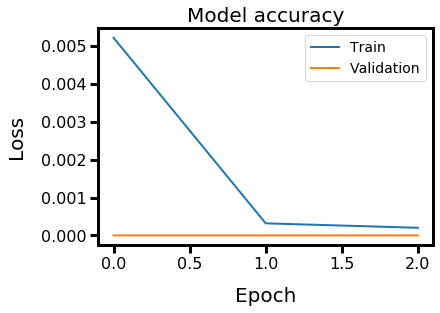

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

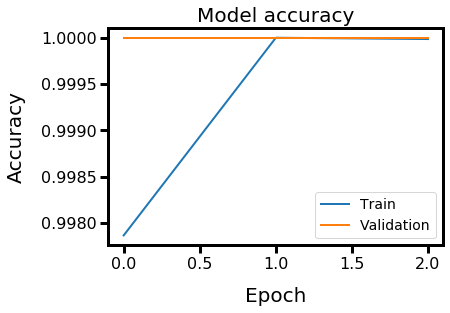

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [19]:
res_test = model.predict(X_test)
res_tc = model.predict(X_critical)

In [20]:
f_tc = int(first_tc / temp_samples)
l_tc = int(last_tc / temp_samples)

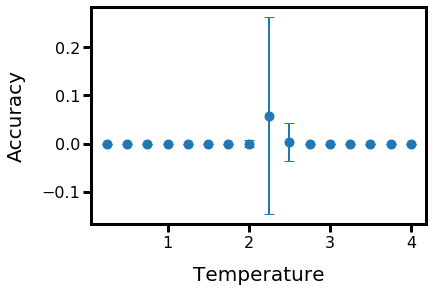

In [21]:
acc = np.zeros(temp_val.shape[0])
acc_std = np.zeros(temp_val.shape[0])

for idx, temp in enumerate(temp_val):
    
    if temp < temp_val[f_tc] or temp >= temp_val[l_tc]:
        
        pos = np.argwhere(Y_test[:, 1] == temp)[:, 0]
    
        aux = res_test[pos, 0] - Y_test[pos, 0]
        acc[idx] = np.mean(np.abs(aux))
        acc_std[idx] = np.std(np.abs(aux))
        
    else:
       
        pos = np.argwhere(Y_critical[:, 1] == temp)[:, 0]
    
        aux = res_tc[pos, 0] - Y_critical[pos, 0]
        acc[idx] = np.mean(np.abs(aux))
        acc_std[idx] = np.std(np.abs(aux))
    
    
plt.errorbar(x=temp_val, y=acc,
             yerr=acc_std, fmt='o', capsize=5)

plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.show()

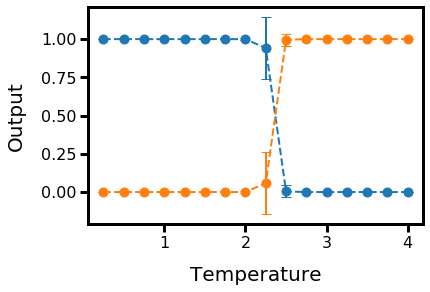

In [22]:
#%matplotlib notebook
output_mean = np.zeros(temp_val.shape[0])
output_std = np.zeros(temp_val.shape[0])

for idx, temp in enumerate(temp_val):
    
    if temp < temp_val[f_tc] or temp >= temp_val[l_tc]:
        
        pos = np.argwhere(Y_test[:, 1] == temp)[:, 0]
    
        output_mean[idx] = np.mean(res_test[pos])
        output_std[idx] = np.std(res_test[pos])
    
    else:
    
        pos = np.argwhere(Y_critical[:, 1] == temp)[:, 0]
        
        output_mean[idx] = np.mean(res_tc[pos])
        output_std[idx] = np.std(res_tc[pos])
    
    
plt.errorbar(x=temp_val, y=output_mean, yerr=output_std,
             fmt='o', capsize=5, linestyle='--')

plt.errorbar(x=temp_val, y=np.abs(output_mean - 1),
             yerr=output_std, fmt='o', capsize=5, linestyle='--')

plt.ylabel('Output')
plt.xlabel('Temperature')
plt.show()